<a href="https://colab.research.google.com/github/DianaDoosti-PouyanBahmani/Intelligent_Systems_Final/blob/main/Task%201/Final_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

!pip install pyswarm
from pyswarm import pso
!pip install deap
from deap import base, creator, tools, algorithms

import random

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=7a93f8d9dc28e1a9093f41b5c104adc71fb582abc065636b8b5eaffd2891f72d
  Stored in directory: /root/.cache/pip/wheels/93/15/89/3970ef96abd6123028010a90f007c4e6a2bed700db0aa2d36a
Successfully built pyswarm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 5.0 MB/s eta 0:00:00


# Read datasets

In [ ]:
data_id = "1jNVAMOZ53r_NltFtqm83d0B5x9Rs7Qqu"

gdown.download(f"https://drive.google.com/uc?id={data_id}", "data.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1jNVAMOZ53r_NltFtqm83d0B5x9Rs7Qqu
To: /content/data.csv
100%|██████████| 37.4k/37.4k [00:00<00:00, 33.3MB/s]


'data.csv'

In [ ]:
df = pd.read_csv("data.csv")

print("Before dropping NaNs")
print(df.shape)

print("\nTrain head:")
print(df.head())

Before dropping NaNs
(614, 12)

Train head:
  Gender Married Dependents     Education Self_Employed  Applicant_Income  \
0   Male      No          0      Graduate            No            584900   
1   Male     Yes          1      Graduate            No            458300   
2   Male     Yes          0      Graduate           Yes            300000   
3   Male     Yes          0  Not Graduate            No            258300   
4   Male      No          0      Graduate            No            600000   

   Coapplicant_Income  Loan_Amount   Term  Credit_History   Area Status  
0                 0.0     15000000  360.0             1.0  Urban      Y  
1            150800.0     12800000  360.0             1.0  Rural      N  
2                 0.0      6600000  360.0             1.0  Urban      Y  
3            235800.0     12000000  360.0             1.0  Urban      Y  
4                 0.0     14100000  360.0             1.0  Urban      Y  


# Drop NaNs

In [ ]:
df = df.dropna()

print("After dropping NaNs")
print(df.shape)

After dropping NaNs
(499, 12)


# Train/Test Split

In [ ]:
TARGET = "Status"

X = df.drop(TARGET, axis=1)
y = df[TARGET]

from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train_df.shape)
print("Test shape :", X_test_df.shape)


Train shape: (349, 11)
Test shape : (150, 11)


# Label Encoding (leakage-free)

In [ ]:
cat_cols = X_train_df.select_dtypes(exclude=np.number).columns

encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train_df[col] = le.fit_transform(X_train_df[col])   # fit on train
    X_test_df[col]  = le.transform(X_test_df[col])        # transform test
    encoders[col] = le

# encode target too
y_le = LabelEncoder()
y_train = y_le.fit_transform(y_train)
y_test  = y_le.transform(y_test)

feature_names = X_train_df.columns

X_train = X_train_df.values
X_test  = X_test_df.values

n_features = X_train.shape[1]

print("Total features:", n_features)

print(X_train_df.head())

Total features: 11
     Gender  Married  Dependents  Education  Self_Employed  Applicant_Income  \
329       0        0           0          0              0            250000   
247       1        1           1          1              0            660800   
80        0        0           0          0              0            384600   
312       0        0           0          0              0            250700   
31        1        0           0          0              0            316700   

     Coapplicant_Income  Loan_Amount   Term  Credit_History  Area  
329                 0.0      6700000  360.0             1.0     2  
247                 0.0     13700000  180.0             1.0     2  
80                  0.0     11100000  360.0             1.0     1  
312                 0.0      5600000  360.0             1.0     0  
31                  0.0      7400000  360.0             1.0     2  


# Baseline Random Forest

In [ ]:
rf = RandomForestClassifier(n_jobs=1, random_state=42, n_estimators=100)

scores = cross_val_score(rf, X_train, y_train, cv=3)
baseline_acc = scores.mean()

rf.fit(X_train, y_train)
baseline_test_acc = rf.score(X_test, y_test)

print("Baseline CV accuracy:", baseline_acc)
print("Baseline Test accuracy:", baseline_test_acc)

Baseline CV accuracy: 0.779275960310443
Baseline Test accuracy: 0.8


# fitness function

In [ ]:
alpha = 0.9

def fitness(mask):
    mask = np.array(mask, dtype=bool)

    if mask.sum() == 0:
        return 1.0

    X_sub = X_train[:, mask]

    model = RandomForestClassifier(
        n_estimators=1,
        n_jobs=1,
        random_state=42
    )

    scores = cross_val_score(model, X_sub, y_train, cv=3)
    acc = scores.mean()

    k = mask.sum()
    d = n_features

    J = alpha*(1-acc) + (1-alpha)*(k/d)

    return J

# PSO Feature Selection

In [ ]:
pso_curve = []
current_iter_best = np.inf
eval_count = 0
swarmsize = 50

def pso_wrapper(x):
    global current_iter_best, eval_count, pso_curve

    mask = np.round(x)

    val = fitness(mask)

    # track best cost within this iteration
    current_iter_best = min(current_iter_best, val)

    eval_count += 1

    # one iteration = swarmsize evaluations
    if eval_count % swarmsize == 0:
        pso_curve.append(current_iter_best)
        current_iter_best = np.inf

    return val

lb = [0] * n_features
ub = [1] * n_features

best_mask, best_fitness = pso(
    pso_wrapper,
    lb, ub,
    swarmsize=swarmsize,
    maxiter=100,
    omega=0.9,
    phip=0.5,
    phig=0.3
)


best_mask = (best_mask > 0.5)

Stopping search: maximum iterations reached --> 100


# Evaluate PSO result

In [ ]:
X_train_pso = X_train[:, best_mask]
X_test_pso  = X_test[:, best_mask]

rf = RandomForestClassifier(n_jobs=1, random_state=42, n_estimators=100)
rf.fit(X_train_pso, y_train)

pso_test_acc = rf.score(X_test_pso, y_test)

pso_features = feature_names[best_mask]

print("PSO Fitness:", best_fitness)
print("PSO Test Accuracy:", pso_test_acc)
print("Selected features:", list(pso_features))

PSO Fitness: 0.18959488787074982
PSO Test Accuracy: 0.8133333333333334
Selected features: ['Credit_History']


# Genetic Algorithm (DEAP)

In [ ]:
ga_curve = []

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_individual(ind):
    val = fitness(ind)
    return (val,)

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=50)

for gen in range(100):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.9, mutpb=0.1)

    fits = list(map(toolbox.evaluate, offspring))
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    pop = toolbox.select(offspring, k=len(pop))

    best = tools.selBest(pop, 1)[0]
    ga_curve.append(best.fitness.values[0])

best_ind = tools.selBest(pop, 1)[0]
best_mask_ga = np.array(best_ind).astype(bool)
best_fitness_ga = best_ind.fitness.values[0]

# Evaluate GA result

In [ ]:
X_train_ga = X_train[:, best_mask_ga]
X_test_ga  = X_test[:, best_mask_ga]

rf = RandomForestClassifier(n_jobs=1, random_state=42, n_estimators=300)
rf.fit(X_train_ga, y_train)

ga_test_acc = rf.score(X_test_ga, y_test)

ga_features = feature_names[best_mask_ga]

print("GA Fitness:", best_fitness_ga)
print("GA Test Accuracy:", ga_test_acc)
print("Selected features:", list(ga_features))

GA Fitness: 0.18959488787074982
GA Test Accuracy: 0.8133333333333334
Selected features: ['Credit_History']


# Convergence Plot

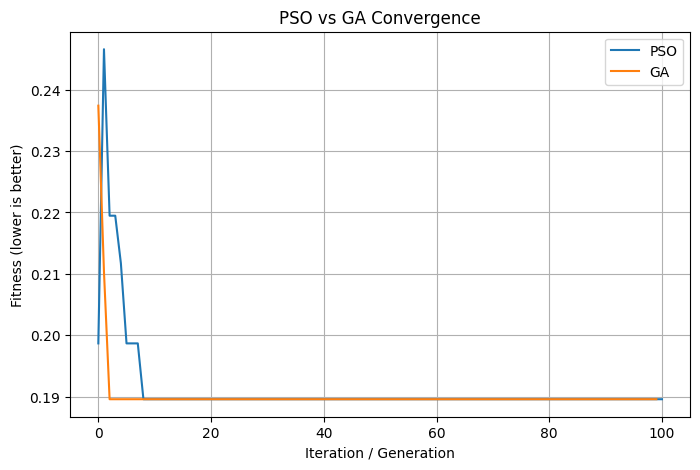

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(pso_curve, label="PSO")
plt.plot(ga_curve, label="GA")

plt.xlabel("Iteration / Generation")
plt.ylabel("Fitness (lower is better)")
plt.title("PSO vs GA Convergence")
plt.legend()
plt.grid()

plt.show()

# Final Summary

In [ ]:
print("\n===== FINAL RESULTS =====")

print("\nBaseline Test Accuracy:", baseline_test_acc)

print("\nPSO:")
print("Fitness:", best_fitness)
print("Accuracy:", pso_test_acc)
print("Features:", len(pso_features))

print("\nGA:")
print("Fitness:", best_fitness_ga)
print("Accuracy:", ga_test_acc)
print("Features:", len(ga_features))



===== FINAL RESULTS =====

Baseline Test Accuracy: 0.8

PSO:
Fitness: 0.18959488787074982
Accuracy: 0.8133333333333334
Features: 1

GA:
Fitness: 0.18959488787074982
Accuracy: 0.8133333333333334
Features: 1


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print(pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=False))

Credit_History        0.230348
Applicant_Income      0.214990
Loan_Amount           0.185612
Coapplicant_Income    0.118434
Area                  0.059521
Term                  0.052453
Dependents            0.050791
Married               0.028328
Education             0.023137
Gender                0.019479
Self_Employed         0.016906
dtype: float64
